In [1]:
from   warnings              import filterwarnings; filterwarnings('ignore')
from   matplotlib            import pyplot as plt
from   mpl_toolkits          import mplot3d

import numpy as np

# %matplotlib notebook

In [2]:
class Grids():
    """
    Base class for GridWorld
    
    Pre-made grids as illustrated in "A Laplacian Framework for Option Discovery in Reinforcement Learning" with an additional "three_rooms" grid
    """
    def get_grid(self, name):
        try:
            return getattr(self, name)()
        except:
            raise Exception(f'"{name}" not recognised!')
    
    @staticmethod
    def ten_by_ten():
        return np.ones((10, 10))
    
    @staticmethod
    def four_rooms():
        grid                      = np.ones((11, 11))
        grid[:,5]                 = 0
        grid[5,:5]                = 0
        grid[6,6:]                = 0
        grid[[2,5,6,9],[5,1,8,5]] = 1
        return grid
    
    @staticmethod
    def i_maze():
        grid             = np.ones((3, 15))
        grid[[0,2],1:-1] = 0
        return grid
    
    @staticmethod
    def three_rooms():
        grid            = np.ones((11, 11))
        grid[:,5]       = 0
        grid[[2, 8], 5] = 1
        grid[5,5:]      = 0
        return grid
    
class GridWorld(Grids):
    """
    GridWorld class for Laplacian computations
    
    ==============
      Parameters
    ==============
    
        grid          : numpy.ndarray
                        an array of values in the set {0, 1}.
                            - 0 indicates a wall
                            - 1 indicates available movement
        
        diffusion     : None, str
                        None          - use the original   laplacian definition
                        "normalised"  - use the normalised laplacian definition
                        "random_walk" - use the normalised random-walk laplacian definition
                    
                        See https://en.wikipedia.org/wiki/Laplacian_matrix#Definition for more details
                    
        pvf_func      : str
                        "eigen"       - eigenvectors
                        "svd"         - left singular vectors
                        
                    
    ==============
        Methods
    ==============
    
        render        : (k, reverse, p, gamma)
                        visualises the environment and if k is provided, the proto value function landscape of the state space
                        k             - basis vector index to use as intrinsic reward function
                        reverse       - if true, e[state_prime] - e[state] otherwise e[state] - e[state_prime] as stated in Definition 3.1 in related paper
                        p             - deterministic setting i.e. 1 for fully deterministic and (0, 1) for stochastic
                        gamma         - discount rate
                        
        value_iterate : (k, reverse, p, gamma)
                        computes the Value table using value iteration
                        k             - basis vector index to use as intrinsic reward function
                        reverse       - if true, e[state_prime] - e[state] otherwise e[state] - e[state_prime] as stated in Definition 3.1 in related paper
                        p             - deterministic setting i.e. 1 for fully deterministic and (0, 1) for stochastic
                        gamma         - discount rate
                        
        r             : (k, reverse, state, state_prime)
                        computes the intrinsic reward for a state transition
                        k             - basis vector index to use as intrinsic reward function
                        reverse       - if true, e[state_prime] - e[state] otherwise e[state] - e[state_prime] as stated in Definition 3.1 in related paper
                        state         - tuple index of where the current state is located
                        state_prime   - tuple index of where the next state is located
    ==============
      Attributes
    ==============
    
        A             : adjacency matrix
        D             : diagonal  matrix which is the row sum of the adjacency matrix
        L             : laplacian matrix
        grid          : numpy.array of the gridworld
        encode        : dictionary translating between adjacency nodes and gridworld coordinates
        lookup        : similar dictionary to encode where the keys and values have been swapped
        e             : Eigen / Singular values
        v             : Eigen / Singular vectors
        
    ==============
    Related Papers
    ==============
    
        https://arxiv.org/pdf/1703.00956.pdf - A Laplacian Framework for Option Discovery in Reinforcement Learning
    """
    def __init__(self, grid, diffusion = None, pvf_func = 'eigen'):
        if isinstance(grid, str):
            self.name         = grid
            grid              = self.get_grid(grid)
        else:
            self.name         = 'custom'
        self._grid            = np.zeros([i + 2 for i in grid.shape])
        self._grid[1:-1,1:-1] = grid
        self.diffusion        = diffusion
        
        for variable in 'ADLev':
            setattr(self, f'_{variable}', None)             
        
        self.pvf              = getattr(self, f'_{pvf_func}')
        
    def render(self, k = None, reverse = False, p = 1, gamma = 0.99):
        """ renders the gridworld """
        num = self.name
        if k is None:
            fig = plt.figure(figsize = (8, 6), num = num)
            self._render()
            V   = None
        else:
            num = num + f' PVF {k + 1}'
            fig = plt.figure(figsize = (16, 6), num = num)
            fig.add_subplot(1, 2, 1)
            plt.title(self.name)
            self._render()
            V   = self._render_annotate(k, reverse, p , gamma)
            ax  = fig.add_subplot(1, 2, 2, projection = '3d')
            self._render_with_pvf(k, V, ax)
        plt.show()
        return V
            
    def value_iterate(self, k, reverse = False, p = 1, gamma = 0.99, theta = 1e-12):
        """ Value iteration algorithm to compute the Value table """
        self.pvf()
        V = np.zeros_like(self.grid)
        while True:
            terminate = []
            old = V.copy()
            for state in zip(*np.where(self._grid)):
                prob = np.eye(4) * p + (1 - p) / 4
                rV   = []
                for state_prime in self.find_adjacent(state):
                    future = state_prime in terminate
                    rV.append(self.r(k, reverse, state, state_prime) + gamma * V[state_prime] * (1 - future))
                V[state] = max(prob.dot(rV))
                if V[state] <= 0:
                    terminate.append(state)
                    V[state] = 0
            err = np.absolute(V - old).max()
            if err < theta: break
        return V, terminate

    def r(self, k, reverse, state, state_prime):
        """ Intrinsic reward function """
        return (-1) ** reverse * (self._v[self.lookup[state_prime],k] - self._v[self.lookup[state],k])
    
    def find_adjacent(self, state):
        """ computes neighbouring states """
        return list(self._find_adjacent(state)) # down, right, down, left
    
    @property
    def grid(self):
        """ Numpy array of grid """
        return self._grid
    
    @property
    def A(self):
        """ adjacency matrix """
        if isinstance(self._A, np.ndarray):
            return self._A
        states  = zip(*np.where(self._grid))
        encode  = self._encode = dict(enumerate(states))
        lookup  = self._lookup = {v : k for k, v in encode.items()}
        self._A = np.zeros((len(encode),) * 2)
        for i, state in encode.items():
            for adj in self.find_adjacent(state):
                j = lookup[adj]
                self._A[i, j] = 1
        return self._A

    @property
    def D(self):
        """ diagonal matrix which is the row sum of the adjacency matrix """
        if isinstance(self._D, np.ndarray):
            return self._D
        self._D = np.diag(self.A.sum(axis = 1))
        return self._D
    
    @property
    def L(self):
        """ laplacian matrix """
        if isinstance(self._L, np.ndarray):
            return self._L
        if self.diffusion is None:
            self._L = self.D - self.A
            return self._L
        elif self.diffusion in ['normalised', 'normalized']:
            rD = np.diag(1 / np.diag(np.sqrt(self.D)))
            self._L = np.eye(len(self.A)) - rD @ self.A @ rD
            return self._L
        elif self.diffusion == 'random_walk':
            self._L = np.eye(len(self.A)) - np.diag(1 / np.diag(self.D)) @ self.A
            return self._L
        raise Exception(f'Diffusion "{self.diffusion}" not recognised!')
        
    @property
    def encode(self):
        if '_encode' in self.__dict__:
            return self._encode
        raise Exception('Adjacency matrix needs to be computed first!')
        
    @property
    def lookup(self):
        if '_lookup' in self.__dict__:
            return self._lookup
        raise Exception('Adjacency matrix needs to be computed first!')
        
    @property
    def e(self):
        """ Eigen / Singular / Independent values """
        if isinstance(self._e, np.ndarray):
            return self._e
        self.pvf()
        return self._e
    
    @property
    def v(self):
        """ Eigen / Singular / Independent vectors """
        if isinstance(self._v, np.ndarray):
            return self._v
        self.pvf()
        return self._v
    
    def _render(self):
        """ Renders the environment """
        plt.imshow(self._grid, cmap = 'magma')
        for i in range(self._grid.shape[0]):
            plt.hlines(i + 0.5, -0.5, self._grid.shape[1] - 0.5, alpha = 0.2)
        for j in range(self._grid.shape[1]):
            plt.vlines(j + 0.5, -0.5, self._grid.shape[0] - 0.5, alpha = 0.2)
        plt.xticks([])
        plt.yticks([])
        
    def _render_annotate(self, k, reverse, p, gamma):
        """ Overlays the policy over the environment """
        V, T   = self.value_iterate(k, reverse, p, gamma)
        policy = np.zeros_like(V, dtype = str)

        for state in zip(*np.where(self.grid)):
            values = [self.r(k, reverse, state, state_prime) + gamma * V[state_prime] for state_prime in self.find_adjacent(state)]
            if len(np.unique(values)) > 1:
                policy[state] = '⇩⇨⇧⇦'[np.argmax(values)]
        
        for state in zip(*np.where(self.grid)):
            if state in T:
                plt.annotate(r'$\mathbf{T}$', state[::-1], va = 'center', ha = 'center', c = 'r')
            else:
                plt.annotate(policy[state], state[::-1], va = 'center', ha = 'center')
        return V
    
    def _render_with_pvf(self, k, V, ax):
        """ Renders the Value table based on a given PVF """
        plt.title(f'PVF {k + 1} ({self.e[k]:.2e})', y = 1.08)
        X, Y = np.meshgrid(range(V.shape[1]), range(V.shape[0]))
        ax.plot_surface(X, Y, V, cmap = 'RdBu', edgecolor='none', vmin = V[np.where(np.isfinite(V))].min(), vmax = V[np.where(np.isfinite(V))].max())
    
    def _find_adjacent(self, state):
        """ helper function for find_adjacent method """
        i, j = state
        yield (i + 1, j) if self._grid[i + 1, j] else (i, j)
        yield (i, j + 1) if self._grid[i, j + 1] else (i, j)
        yield (i - 1, j) if self._grid[i - 1, j] else (i, j)
        yield (i, j - 1) if self._grid[i, j - 1] else (i, j)
        
    def _eigen(self):
        """ computes values and basis vectors using the eigenvalue decomposition """
        e, v    = np.linalg.eig(self.L)
        o       = e.argsort()
        self._e = e[o]
        self._v = v[:,o]
        
    def _svd(self):
        """ computes values and basis vectors using the singular value decomposition """
        v, e,_  = np.linalg.svd(self.L, full_matrices = False)
        self._e = e[::-1]
        self._v = v[:,::-1]

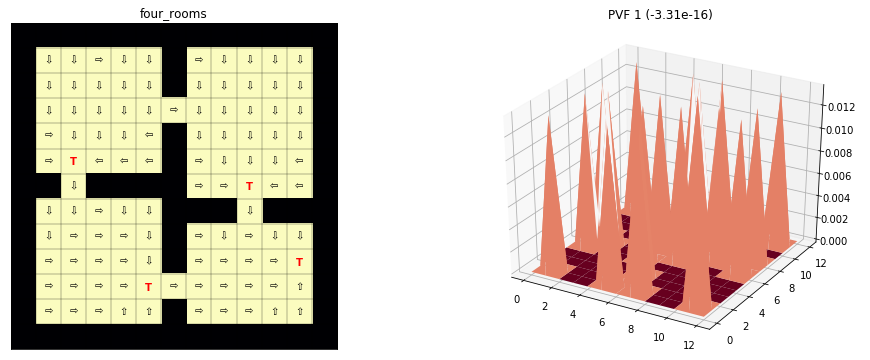

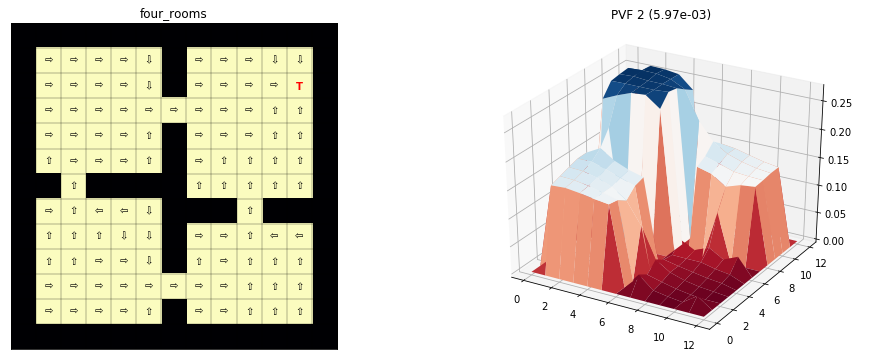

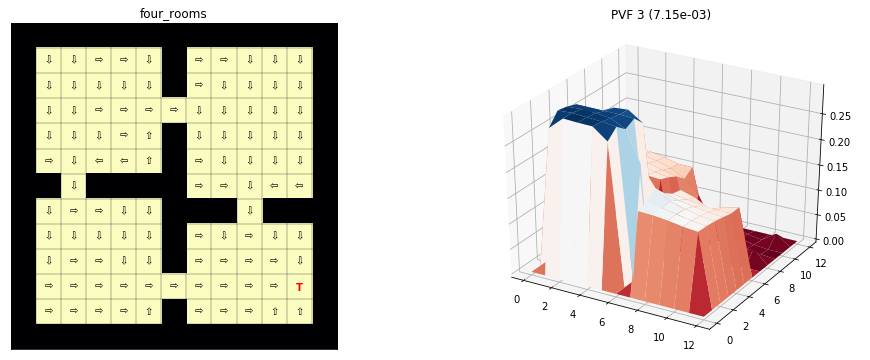

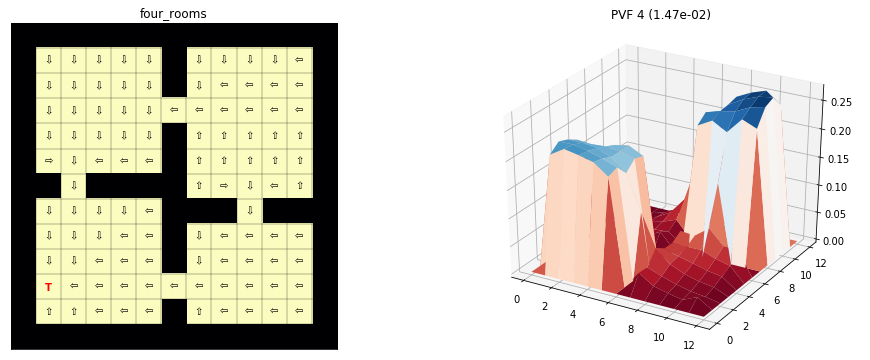

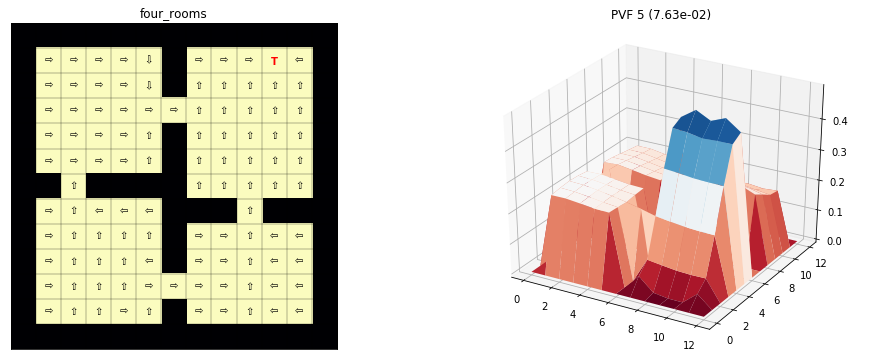

In [3]:
env  = GridWorld(grid = 'four_rooms', diffusion = 'normalised', pvf_func = 'eigen')

for i in range(5):
    V    = env.render(i)

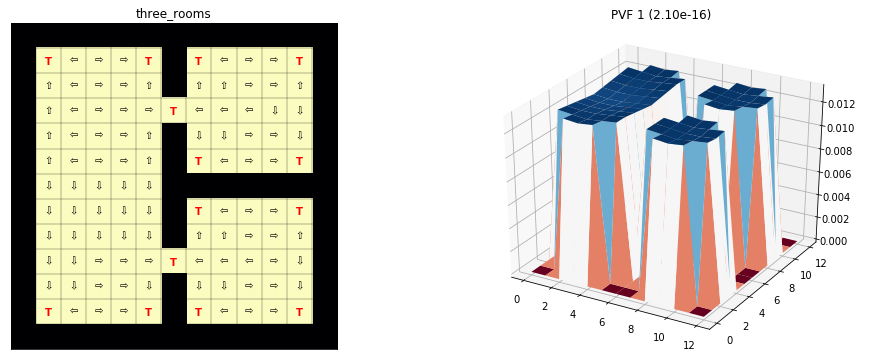

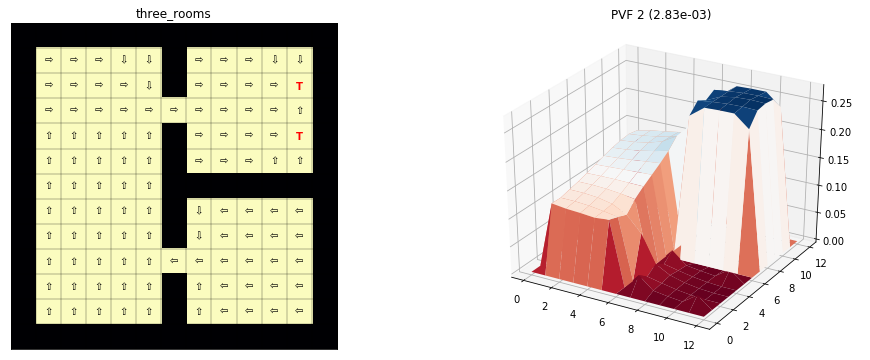

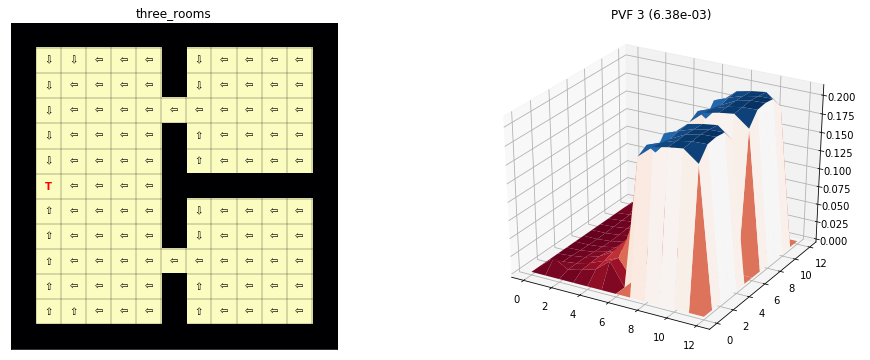

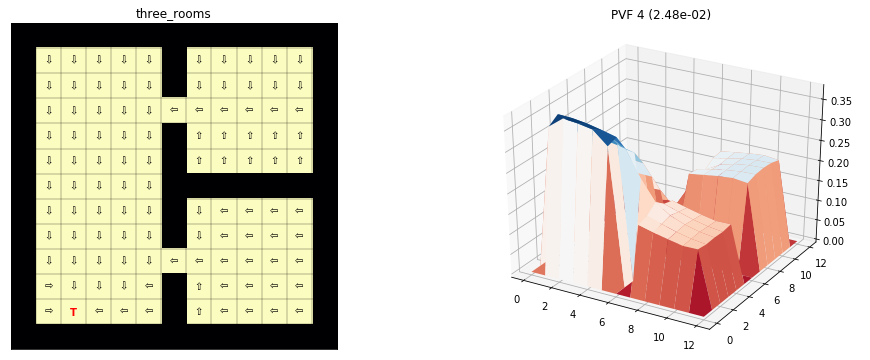

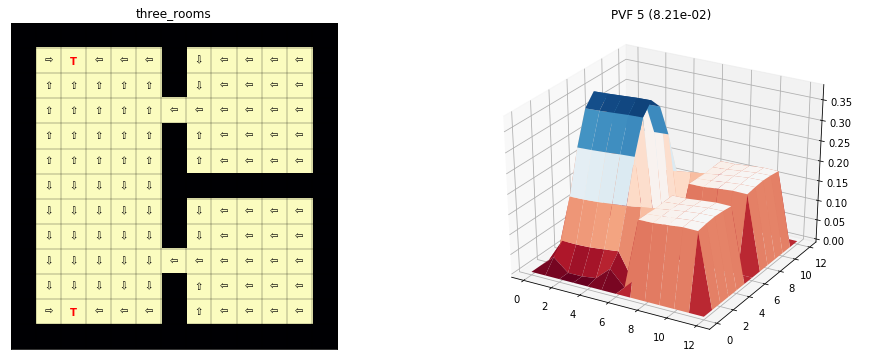

In [4]:
env  = GridWorld(grid = 'three_rooms', diffusion = 'normalised', pvf_func = 'eigen')

for i in range(5):
    V    = env.render(i)

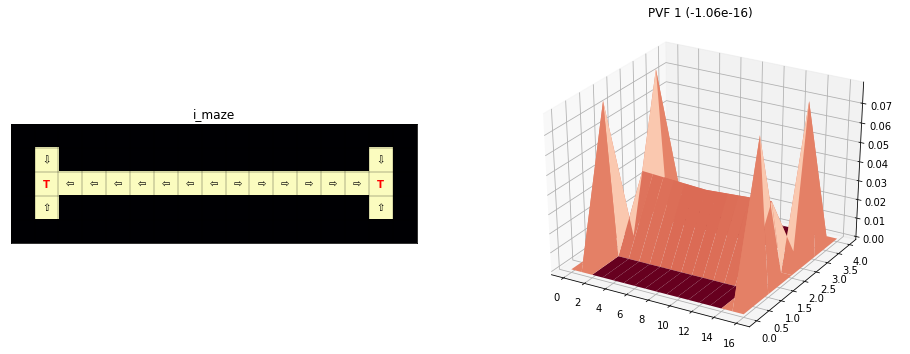

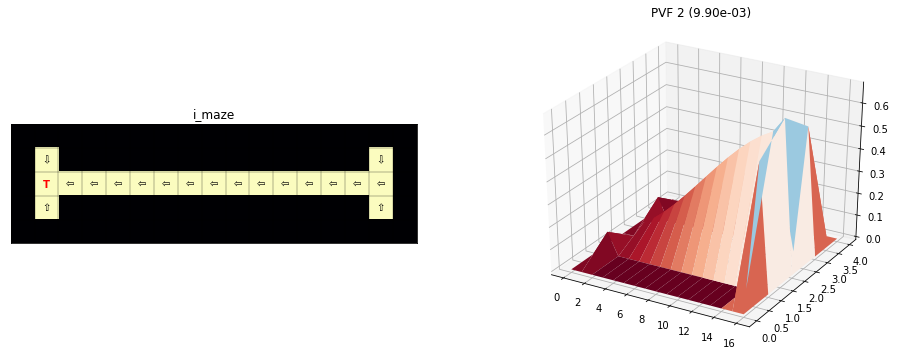

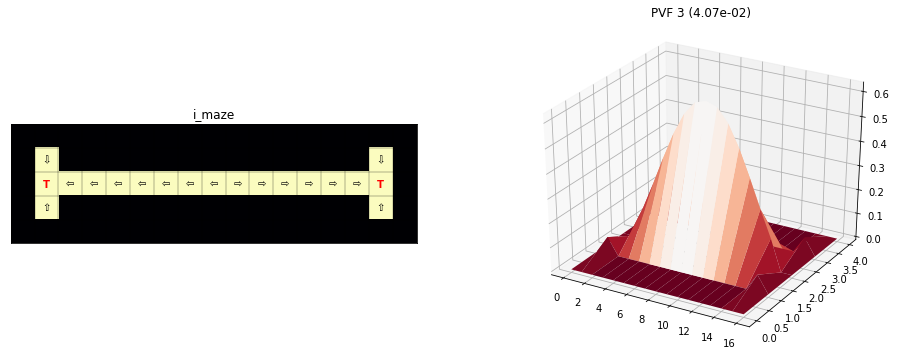

In [5]:
env  = GridWorld(grid = 'i_maze', diffusion = 'normalised', pvf_func = 'eigen')

for i in range(3):
    V    = env.render(i)

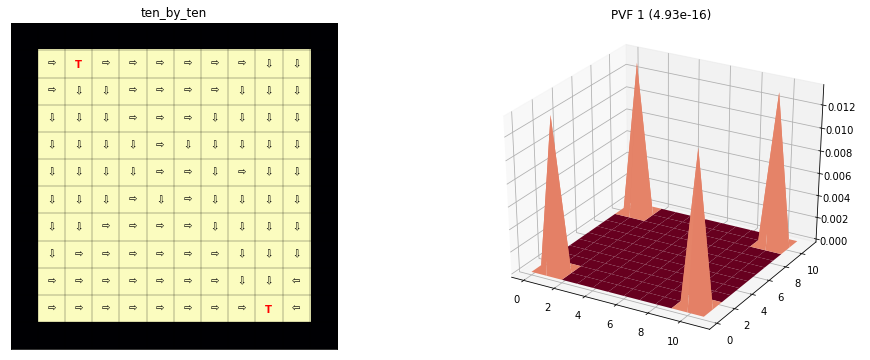

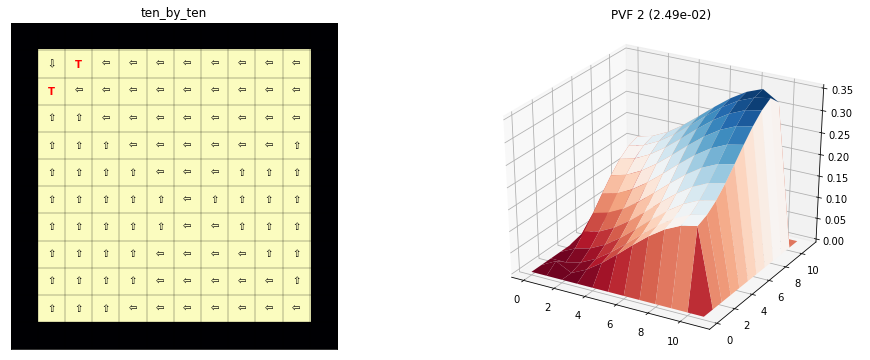

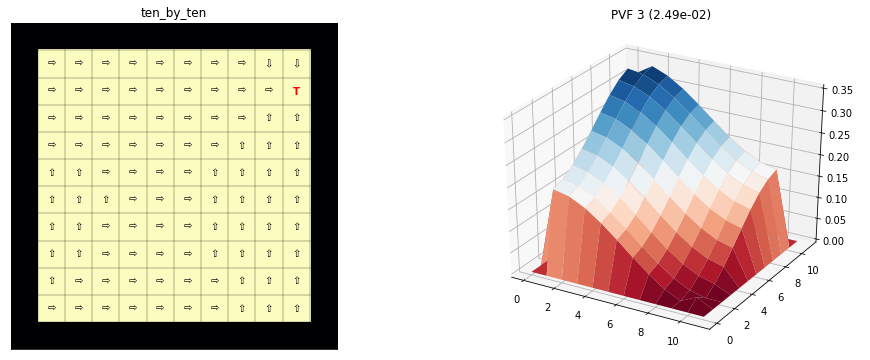

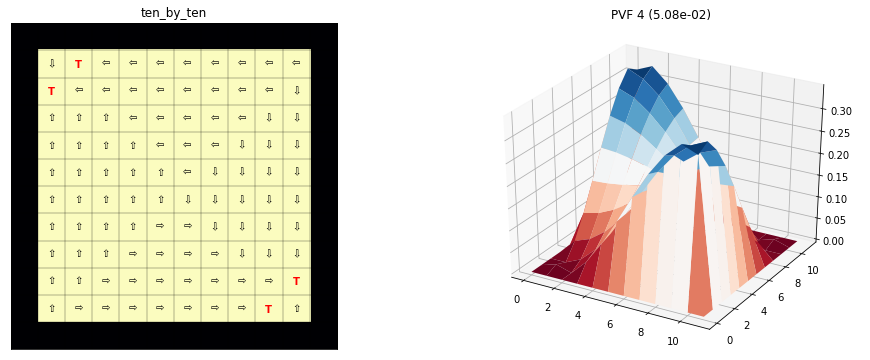

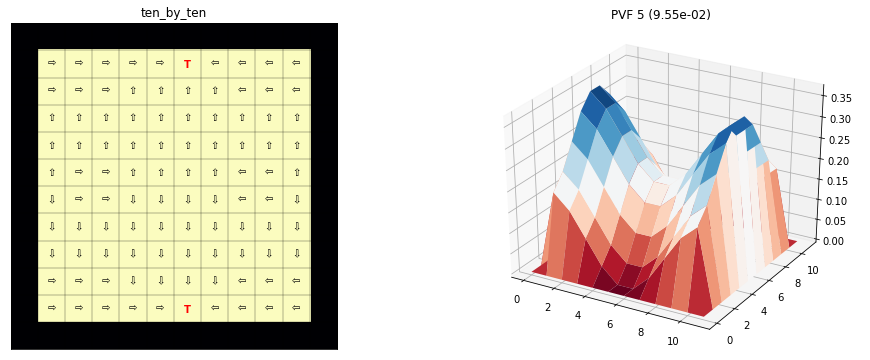

In [6]:
env  = GridWorld(grid = 'ten_by_ten', diffusion = 'normalised', pvf_func = 'eigen')

for i in range(5):
    V    = env.render(i)